In [1]:
import os
import json
import wandb
import hoomd
import codecs

import numpy as np

import polychrom_hoomd.log as log
import polychrom_hoomd.build as build
import polychrom_hoomd.forces as forces
import polychrom_hoomd.render as render

from polychrom_hoomd.utils import get_chrom_bounds

from polykit.analysis.polymer_analyses import Rg2
from polykit.generators.initial_conformations import grow_cubic

In [2]:
# Initialise HooMD on the CPU or GPU, based on availability
hoomd_device = hoomd.device.GPU(gpu_ids=[3])

In [3]:
# Generate RNG seed
rng_seed = os.urandom(2)
rng_seed = int(codecs.encode(rng_seed, 'hex'), 16)

print("Using entropy-harvested random seed: %d" % rng_seed)

Using entropy-harvested random seed: 37355


In [4]:
# Initialize empty simulation object
system = hoomd.Simulation(device=hoomd_device, seed=rng_seed)

In [5]:
# Simulate two chromosomes comprised of 5000 (resp. 10000) monomers each, with number density 0.2
density = 0.2
chromosome_sizes = [1000]

In [6]:
# Initialize simulation with the appropriate box size 
number_of_monomers = sum(chromosome_sizes)
L = (number_of_monomers/density) ** (1/3.)

snapshot = build.get_simulation_box(box_length=L)

In [7]:
# Build random, dense initial conformations
monomer_positions = grow_cubic(N=number_of_monomers, boxSize=int(L-2))

In [8]:
# Populate snapshot with the generated chains
build.set_chains(snapshot, monomer_positions, chromosome_sizes)

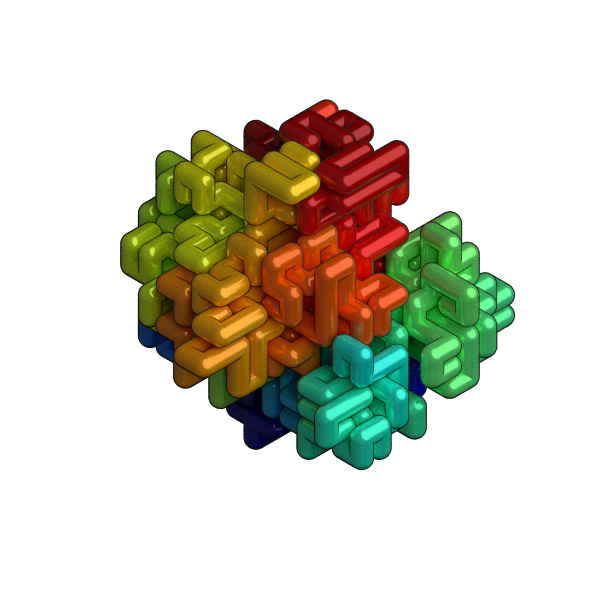

In [9]:
# Visualize starting conformation using the Fresnel backend
render.fresnel(snapshot, cmap="jet").static(pathtrace=True)

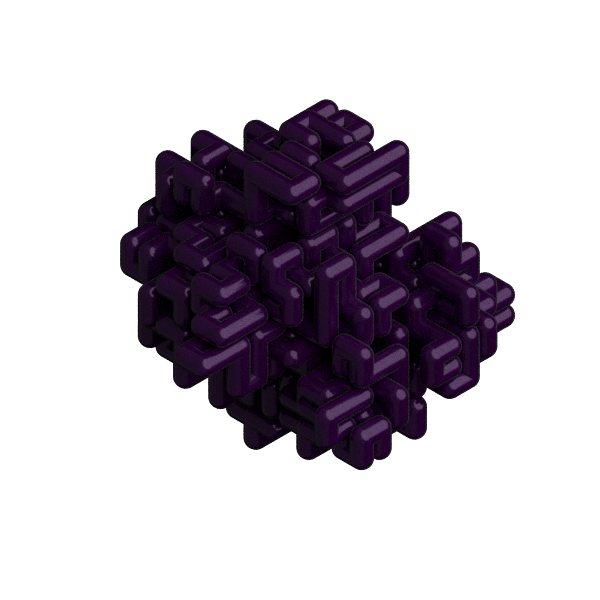

In [10]:
# Render individual chromosomes
render.fresnel(snapshot, show_chromosomes=True).static(pathtrace=True)

In [11]:
# Setup HooMD simulation object
system.create_state_from_snapshot(snapshot)

In [12]:
# Setup neighbor list
nl = hoomd.md.nlist.Cell(buffer=0.4)

In [13]:
# Read input force parameters
with open("force_dict_heteropolymer.json", 'r') as dict_file:
    force_dict = json.load(dict_file)

print(json.dumps(force_dict, indent=4, sort_keys=True))

{
    "Angular forces": {
        "Curvature": {
            "Stiffness": 1.5,
            "Type": "Harmonic"
        }
    },
    "Bonded forces": {
        "Backbone": {
            "Rest length": 1.0,
            "Type": "Harmonic",
            "Wiggle distance": 0.1
        }
    },
    "External forces": {
        "Confinement": {}
    },
    "Non-bonded forces": {
        "Repulsion": {
            "Cutoff": 1.0,
            "Matrix": {
                "A": {
                    "A": 5.0,
                    "B": 5.0
                },
                "B": {
                    "A": 5.0,
                    "B": 5.0
                }
            },
            "Type": "Polychrom"
        }
    }
}


In [14]:
# Set a pseudo square well attraction force acting on B-type monomers
force_dict["Non-bonded forces"]["Attraction"] = {
    "Cutoff": 1.5,
    "Matrix": {
        "A": {
            "A": 0,
            "B": 0
        },
        "B": {
            "A": 0,
            "B": 0
        }
    },
    "Type": "Polychrom"
}

In [15]:
# Set chromosome excluded volume
repulsion_forces = forces.get_repulsion_forces(nl, **force_dict)

In [16]:
# Set bonded/angular potentials
bonded_forces = forces.get_bonded_forces(**force_dict)
angular_forces = forces.get_angular_forces(**force_dict)
attraction_forces = forces.get_attraction_forces(nl, **force_dict)

In [17]:
# Set DPD forces
dpd_forces = forces.get_dpd_forces(nl, **force_dict)

Setting up DPD with the conservative force contribution disabled


In [18]:
# Define full force_field
force_field = repulsion_forces + bonded_forces + angular_forces + dpd_forces + attraction_forces

In [19]:
# Setup new DPD integrator
nve = hoomd.md.methods.NVE(filter=hoomd.filter.All())
dpd_integrator = hoomd.md.Integrator(dt=5e-3, methods=[nve], forces=force_field)

/home/max_tortora/.conda/envs/polychrom-hoomd/lib/python3.10/site-packages/hoomd/md/methods/methods.py:699: FutureWarning: NVE is deprecated and wil be removed in hoomd 4.0. In version 4.0, use the ConstantVolume method without a thermostat.
  warnings.warn(


In [20]:
logger = log.get_logger(system)

In [21]:
class RGWriter(hoomd.custom.Action):
    def __init__(self, project_name: str = 'hoomd'):
        self.run = wandb.init(project=project_name)
        self.file = {}

    def act(self, timestep):
        """Write out a new frame to the trajectory."""
        snapshot = self._state.get_snapshot()

        positions = snapshot.particles.position.copy()
        box = np.asarray(snapshot.configuration.box)[None, :3]

        chrom_bounds = get_chrom_bounds(snapshot)
        rg = np.zeros(len(chrom_bounds))

        for i, bounds in enumerate(chrom_bounds):
            chrom_positions = positions[bounds[0]:bounds[1]+1]
            
            bond_vectors = chrom_positions[1:] - chrom_positions[:-1]
            PBC_shifts = np.round(bond_vectors / box)
                
            chrom_positions[1:] -= np.cumsum(PBC_shifts, axis=0) * box
            rg[i] = Rg2(chrom_positions)

        rg_mean = np.mean(rg)
        self.file[timestep] = rg_mean

        wandb.log({"timestep": timestep, "Rg": rg_mean})

In [22]:
# Update simulation engine
system.operations.integrator = dpd_integrator

system.operations.writers.append(log.table_formatter(logger, period=1e4))
system.operations.writers.append(hoomd.write.CustomWriter(action=RGWriter('hoomd'), trigger=1e4))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: maxime-tortora (maxime_tortora). Use `wandb login --relogin` to force relogin


In [23]:
# Run
system.run(2e5)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
       10000           6687.48466     0:00:28.411280           0.78799          
       20000           8454.15989     0:00:21.291294           0.90786          
       30000           9267.79793     0:00:18.343084           0.97472          
       40000           9711.77641     0:00:16.474844           0.96295          
       50000          10018.95022     0:00:14.971628           1.03013          
       60000          10236.91866     0:00:13.675990           1.00558          
       70000          10383.80578     0:00:12.519495           0.99861          
       80000          10508.39046     0:00:11.419446           1.00209          
       90000          10612.13979     0:00:10.365487           1.03413          
      100000          10678.87117     0:00:09.364286           1.04049          
      110000          10747.67570     0:00:08.373904           0.96740          
      120000          10803.